In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error

### Electricity Data

In [2]:

# File Paths
Elec_path = 'https://raw.githubusercontent.com/Aadam03/Efficient-Use-of-Energy/main/Elec%20Data.csv'

# Read CSV and convert 'Start' to datetime
elec_data = pd.read_csv(Elec_path)
elec_data['date'] = pd.to_datetime(elec_data[' Start'], utc=True)
elec_data['date'] = elec_data['date'].dt.date
# Group by date and sum the 'Consumption (kWh)' column
elec_daily_consumption = elec_data.groupby(elec_data['date'])['Consumption (kWh)'].sum().reset_index()  #KWh


### Gas Data


In [3]:
# File Paths
Gas_path = 'https://raw.githubusercontent.com/Aadam03/Efficient-Use-of-Energy/main/Gas%20Data.csv'

# Read CSV and convert 'Start' to datetime
Gas_data = pd.read_csv(Gas_path)
Gas_data['date'] = pd.to_datetime(Gas_data[' Start'], utc=True) # Daily Data
Gas_data['date'] = Gas_data['date'].dt.date
# Group by date and sum the 'Consumption (kWh)' column
Gas_daily_consumption_vol = Gas_data.groupby(Gas_data['date'])['Consumption (m³)'].sum().reset_index() #m^3
Gas_daily_consumption = Gas_daily_consumption_vol['Consumption (m³)'] * 1.02264 *  39.1 /  3.6 #kWh
Gas_daily_consumption = pd.DataFrame({'Consumption (Kwh)': Gas_daily_consumption, 'Date': Gas_daily_consumption_vol['date']})

### Reading Temperature Data

In [4]:

Path = 'https://github.com/Aadam03/Efficient-Use-of-Energy/raw/main/Birmingham%20Weather%20Data.xlsx'

weather_data = pd.read_excel(Path)


weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

weather_data_relevant_daily = weather_data[(weather_data['datetime'] >= '2023-11-01')]
weather_data_relevant_daily = weather_data_relevant_daily[(weather_data_relevant_daily['datetime'] <= '2024-02-03')]


weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
# Set 'date' as the index
weather_data.set_index('datetime', inplace=True)

# Resample data to weekly frequency and sum the values
weather_data_weekly = weather_data.resample('W-Mon').mean()

# Reset the index to make 'date' a regular column again
weather_data_weekly.reset_index(inplace=True)

weather_data.reset_index(inplace=True)

weather_data_relevant_weekly = weather_data_weekly[(weather_data_weekly['datetime'] >= '2023-11-01')]
weather_data_relevant_weekly = weather_data_relevant_weekly[(weather_data_relevant_weekly['datetime'] <= '2024-02-06')]


<ipython-input-4-f12e80c396e3>:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weather_data_weekly = weather_data.resample('W-Mon').mean()


### Changing Daily Data to weekly

In [5]:
#Electricity

elec_daily_consumption['date'] = pd.to_datetime(elec_daily_consumption['date'])
# Set 'date' as the index
elec_daily_consumption.set_index('date', inplace=True)

# Resample data to weekly frequency and sum the values
elec_weekly = elec_daily_consumption.resample('W-Mon').sum()

# Reset the index to make 'date' a regular column again
elec_weekly.reset_index(inplace=True)
elec_daily_consumption.reset_index(inplace=True)

#Gas

Gas_daily_consumption['Date'] = pd.to_datetime(Gas_daily_consumption['Date'])
# Set 'date' as the index
Gas_daily_consumption.set_index('Date', inplace=True)

# Resample data to weekly frequency and sum the values
Gas_weekly = Gas_daily_consumption.resample('W-Mon').sum()

# Reset the index to make 'date' a regular column again
Gas_weekly.reset_index(inplace=True)

Gas_daily_consumption.reset_index(inplace=True)

H = elec_daily_consumption[elec_daily_consumption['date']<='2023-12-31']
H = H[H['date']>='2023-01-01']

H['Consumption (kWh)'].sum()


# k= Gas_daily_consumption[Gas_daily_consumption['Date']<='2023-12-31']
# k = k[k['Date']>='2023-01-01']

# k['Consumption (Kwh)'].sum()

3256.442

### Getting Relevant Data for both elec and GAS

In [6]:


# Convert 'date_column' to datetime type
#elec_daily_consumption['date'] = pd.to_datetime(elec_daily_consumption['date'])

# Set a specific date threshold
threshold_date = pd.to_datetime('2023-11-01')

# Filter rows after the threshold date
filtered_elec_daily = elec_daily_consumption[elec_daily_consumption['date'] >= threshold_date]
filtered_gas_daily = Gas_daily_consumption[Gas_daily_consumption['Date'] >= threshold_date]


#turning these into weekly

# electrivity

# Set 'date' as the index
filtered_elec_daily.set_index('date', inplace=True)

# Resample data to weekly frequency and sum the values
filtered_elec_weekly = filtered_elec_daily.resample('W-Mon').sum()

# Reset the index to make 'date' a regular column again
filtered_elec_weekly.reset_index(inplace=True)
filtered_elec_daily.reset_index(inplace=True)


#Gas

# Set 'date' as the index
filtered_gas_daily.set_index('Date', inplace=True)

# Resample data to weekly frequency and sum the values
filtered_gas_weekly = filtered_gas_daily.resample('W-Mon').sum()

# Reset the index to make 'date' a regular column again
filtered_gas_weekly.reset_index(inplace=True)
filtered_gas_daily.reset_index(inplace=True)






### Getting Nicer X axis

In [7]:
# Convert the 'Date' column to the desired format (yy-mm)
filtered_gas_weekly['Nice Date'] = filtered_gas_weekly['Date'].dt.strftime('%y-%m')

# Add a new column with week information (e.g., 'Week 1', 'Week 2', ...)
filtered_gas_weekly['Week'] = filtered_gas_weekly['Date'].dt.strftime('Week %U')




### Weekly regression on date







In [8]:
# Electric

filtered_elec_weekly['date'] = pd.to_datetime(filtered_elec_weekly['date'])

# Convert datetime to numerical representation (e.g., days since the start date)
filtered_elec_weekly['NumericalDate'] = (filtered_elec_weekly['date'] - filtered_elec_weekly['date'].min()).dt.days

# Perform regression using NumPy
coefficients_1 = np.polyfit(weather_data_relevant_weekly['temp'], filtered_elec_weekly['Consumption (kWh)'], deg=1)
poly1 = np.poly1d(coefficients_1)


slope_1, intercept_1, r_value_1, p_value_1, std_err_1 = linregress(weather_data_relevant_weekly['temp'], filtered_elec_weekly['Consumption (kWh)'])
r_squared_1 = r_value_1**2


# Compute predicted values
predicted_values = slope_1 * weather_data_relevant_weekly['temp'] + intercept_1

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(filtered_elec_weekly['Consumption (kWh)'], predicted_values))

# Calculate the range of the target variable
target_range = filtered_elec_weekly['Consumption (kWh)'].max() - filtered_elec_weekly['Consumption (kWh)'].min()

# Calculate normalized RMSE
normalized_rmse1 = rmse / target_range






slope_1a, intercept_1a, r_value_1a, p_value_1a, std_err_1a = linregress(weather_data_relevant_weekly['feelslike'], filtered_elec_weekly['Consumption (kWh)'])
r_squared_1a = r_value_1a**2


# Compute predicted values
predicted_values_a = slope_1a * weather_data_relevant_weekly['feelslike'] + intercept_1a

# Calculate RMSE
rmse_a = np.sqrt(mean_squared_error(filtered_elec_weekly['Consumption (kWh)'], predicted_values_a))

# Calculate the range of the target variable
target_range_a = filtered_elec_weekly['Consumption (kWh)'].max() - filtered_elec_weekly['Consumption (kWh)'].min()

# Calculate normalized RMSE
normalized_rmse_a = rmse_a / target_range_a



# Save statistical Parameters

Weekly_elec_stats = {
    'slope': slope_1,
    'intercept': intercept_1,
    'r_squared': r_squared_1,
    'p_value': p_value_1,
    'std_err': std_err_1
}


#Gas


filtered_gas_weekly['Date'] = pd.to_datetime(filtered_gas_weekly['Date'])

# Convert datetime to numerical representation (e.g., days since the start date)
filtered_gas_weekly['NumericalDate'] = (filtered_gas_weekly['Date'] - filtered_gas_weekly['Date'].min()).dt.days

# Perform regression using NumPy

coefficients_2 = np.polyfit(weather_data_relevant_weekly['temp'], filtered_gas_weekly['Consumption (Kwh)'], deg=1)
poly2 = np.poly1d(coefficients_2)


# Calculate R-squared and other statistical parameters using scipy's linregress
slope2, intercept2, r_value2, p_value2, std_err2 = linregress(weather_data_relevant_weekly['temp'], filtered_gas_weekly['Consumption (Kwh)'])
r_squared2 = r_value2**2


# Compute predicted values
predicted_values_gas = slope2 * weather_data_relevant_weekly['temp'] + intercept2

# Calculate RMSE
rmse_gas = np.sqrt(mean_squared_error(filtered_gas_weekly['Consumption (Kwh)'], predicted_values_gas))

# Calculate the range of the target variable
target_range_gas = filtered_gas_weekly['Consumption (Kwh)'].max() - filtered_gas_weekly['Consumption (Kwh)'].min()

# Calculate normalized RMSE
normalized_rmse_gas = rmse_gas / target_range_gas




# Calculate R-squared and other statistical parameters using scipy's linregress
slope2a, intercept2a, r_value2a, p_value2a, std_err2a = linregress(weather_data_relevant_weekly['feelslike'], filtered_gas_weekly['Consumption (Kwh)'])
r_squared2a = r_value2a**2

# Compute predicted values
predicted_values_gas_a = slope2a * weather_data_relevant_weekly['feelslike'] + intercept2a

# Calculate RMSE
rmse_gas_a = np.sqrt(mean_squared_error(filtered_gas_weekly['Consumption (Kwh)'], predicted_values_gas_a))

# Calculate the range of the target variable
target_range_gas_a = filtered_gas_weekly['Consumption (Kwh)'].max() - filtered_gas_weekly['Consumption (Kwh)'].min()

# Calculate normalized RMSE
normalized_rmse_gas_a = rmse_gas_a / target_range_gas_a

RMSE_winter_reg = {
    'Elec_T ' : normalized_rmse1,
    'Elec_FT' : normalized_rmse_a,
    'Gas_T'   : normalized_rmse_gas,
    'Gas_FT'  : normalized_rmse_gas_a
}






Weekly_gas_stats = {
    'slope': slope2,
    'intercept': intercept2,
    'r_squared': r_squared2,
    'p_value': p_value2,
    'std_err': std_err2
}




In [9]:

normalized_rmse1

0.2707801542355633

### Daily regression

In [10]:
filtered_elec_daily['NumericalDate'] = (filtered_elec_daily['date'] - filtered_elec_daily['date'].min()).dt.days



# Electric

filtered_elec_daily['date'] = pd.to_datetime(filtered_elec_daily['date'])

# Convert datetime to numerical representation (e.g., days since the start date)
filtered_elec_daily['NumericalDate'] = (filtered_elec_daily['date'] - filtered_elec_daily['date'].min()).dt.days

# Perform regression using NumPy
coefficients = np.polyfit(weather_data_relevant_daily['temp'], filtered_elec_daily['Consumption (kWh)'], deg=1)
poly3 = np.poly1d(coefficients)


# Calculate R-squared and other statistical parameters using scipy's linregress
slope, intercept, r_value_ed, p_value, std_err = linregress(weather_data_relevant_daily['temp'], filtered_elec_daily['Consumption (kWh)'])
r_squared_ed = r_value_ed**2


# Compute predicted values
predicted_values_ed = slope * weather_data_relevant_daily['temp'] + intercept

# Calculate RMSE
rmse_ed = np.sqrt(mean_squared_error(filtered_elec_daily['Consumption (kWh)'], predicted_values_ed))

# Calculate the range of the target variable
target_range_ed = filtered_elec_daily['Consumption (kWh)'].max() - filtered_elec_daily['Consumption (kWh)'].min()

# Calculate normalized RMSE
normalized_rmse_ed = rmse_ed / target_range_ed

print(normalized_rmse_ed)


Daily_elec_stats = {
    'slope': slope,
    'intercept': intercept,
    'r_squared': r_squared_ed,
    'p_value': p_value,
    'std_err': std_err
}
# Gas

filtered_gas_daily['Date'] = pd.to_datetime(filtered_gas_daily['Date'])

# Convert datetime to numerical representation (e.g., days since the start date)
filtered_gas_daily['NumericalDate'] = (filtered_gas_daily['Date'] - filtered_gas_daily['Date'].min()).dt.days

# Perform regression using NumPy
coefficients = np.polyfit(weather_data_relevant_daily['temp'], filtered_gas_daily['Consumption (Kwh)'], deg=1)
poly4 = np.poly1d(coefficients)


# Calculate R-squared and other statistical parameters using scipy's linregress
slope, intercept, r_value_ge, p_value, std_err = linregress(weather_data_relevant_daily['temp'], filtered_gas_daily['Consumption (Kwh)'])
r_squared_ge = r_value_ge**2

# Compute predicted values
predicted_values_ge = slope * weather_data_relevant_daily['temp'] + intercept

# Calculate RMSE
rmse_ge = np.sqrt(mean_squared_error(filtered_gas_daily['Consumption (Kwh)'], predicted_values_ge))

# Calculate the range of the target variable
target_range_ge = filtered_gas_daily['Consumption (Kwh)'].max() - filtered_gas_daily['Consumption (Kwh)'].min()

# Calculate normalized RMSE
normalized_rmse_ge = rmse_ge / target_range_ge

Daily_gas_stats = {
    'slope': slope,
    'intercept': intercept,
    'r_squared': r_squared_ge,
    'p_value': p_value,
    'std_err': std_err
}


0.17872978433029627


<ipython-input-10-666e4b2053bd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_elec_daily['NumericalDate'] = (filtered_elec_daily['date'] - filtered_elec_daily['date'].min()).dt.days
<ipython-input-10-666e4b2053bd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_elec_daily['date'] = pd.to_datetime(filtered_elec_daily['date'])
<ipython-input-10-666e4b2053bd>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

### Plotting

Elec Weekly

In [11]:
# @title Data Handling and electrical regression daily basis
filtered_gas_daily['Date'] = pd.to_datetime(filtered_gas_daily['Date'])

# Convert datetime to numerical representation (e.g., days since the start date)
filtered_gas_daily['NumericalDate'] = (filtered_gas_daily['Date'] - filtered_gas_daily['Date'].min()).dt.days

# Perform regression using NumPy
coefficients = np.polyfit(filtered_gas_daily['NumericalDate'], filtered_gas_daily['Consumption (Kwh)'], deg=1)
poly4 = np.poly1d(coefficients)


date = pd.to_datetime(weather_data_relevant_weekly['datetime'])
consumption = filtered_elec_weekly['Consumption (kWh)']




<ipython-input-11-3f25d1b169e7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gas_daily['Date'] = pd.to_datetime(filtered_gas_daily['Date'])
<ipython-input-11-3f25d1b169e7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gas_daily['NumericalDate'] = (filtered_gas_daily['Date'] - filtered_gas_daily['Date'].min()).dt.days


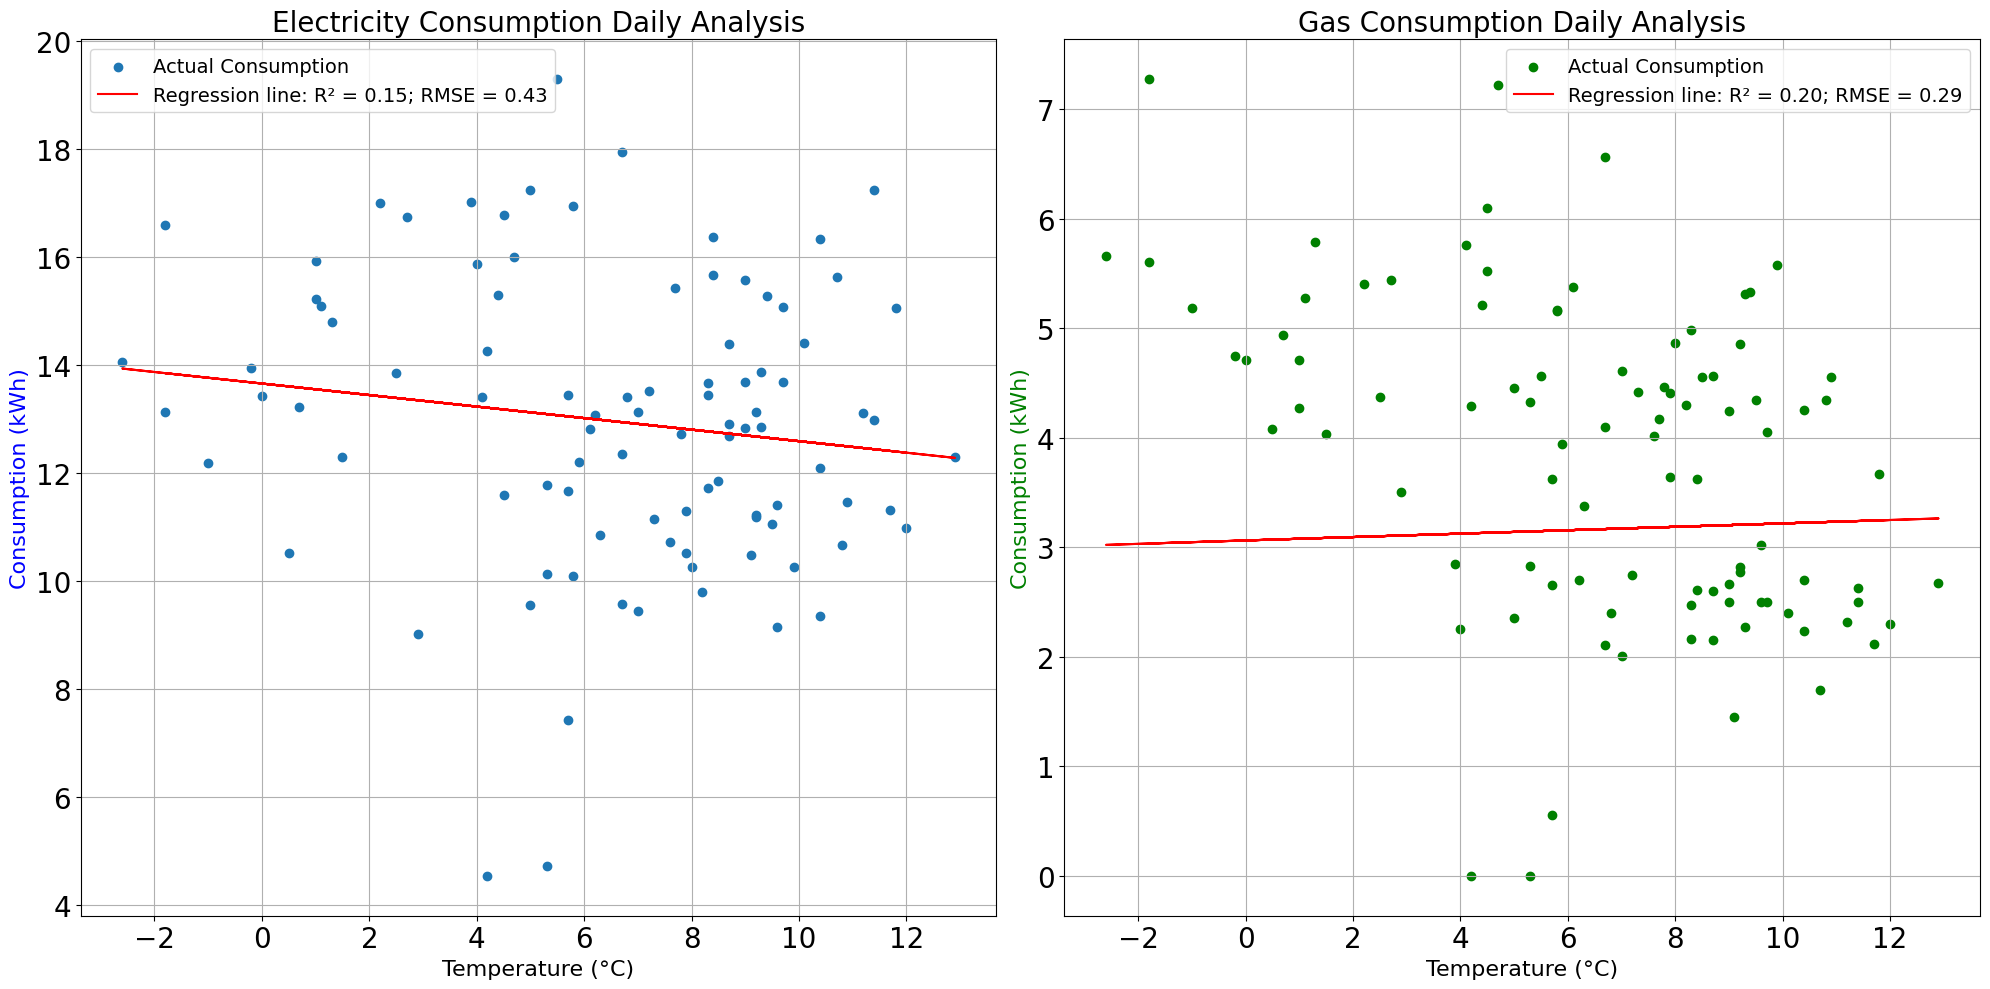

In [12]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot for Electricity Consumption Daily Analysis
axs[0].scatter(weather_data_relevant_daily['temp'], filtered_elec_daily['Consumption (kWh)'], label='Actual Consumption')
axs[0].plot(weather_data_relevant_daily['temp'], poly3(weather_data_relevant_daily['temp']), color='red', label=f'Regression line: R² = {0.15:.2f}''; RMSE = 0.43')
axs[0].set_xlabel('Temperature (°C)', fontsize=16)
axs[0].set_ylabel('Consumption (kWh)', fontsize=16,color = 'blue')
axs[0].set_title('Electricity Consumption Daily Analysis', fontsize=20)
axs[0].grid()
axs[0].legend(fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=20)  # Increase tick size

# Plot for Gas Consumption Daily Analysis
axs[1].scatter(weather_data_relevant_daily['temp'], filtered_gas_daily['Consumption (Kwh)'], color='green', label='Actual Consumption')
axs[1].plot(weather_data_relevant_daily['temp'], poly4(weather_data_relevant_daily['temp']), color='red', label=f'Regression line: R² = {0.2:.2f}' '; RMSE = 0.29')
axs[1].set_xlabel('Temperature (°C)', fontsize=16)
axs[1].set_ylabel('Consumption (kWh)', fontsize=16,color = 'green')
axs[1].set_title('Gas Consumption Daily Analysis', fontsize=20)
axs[1].grid()
axs[1].legend(fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=20)  # Increase tick size

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

Gas Weekly

In [13]:
# @title Gas data handling weekly basis
date = pd.to_datetime(weather_data_relevant_weekly['datetime'])
consumption = filtered_gas_weekly['Consumption (Kwh)']


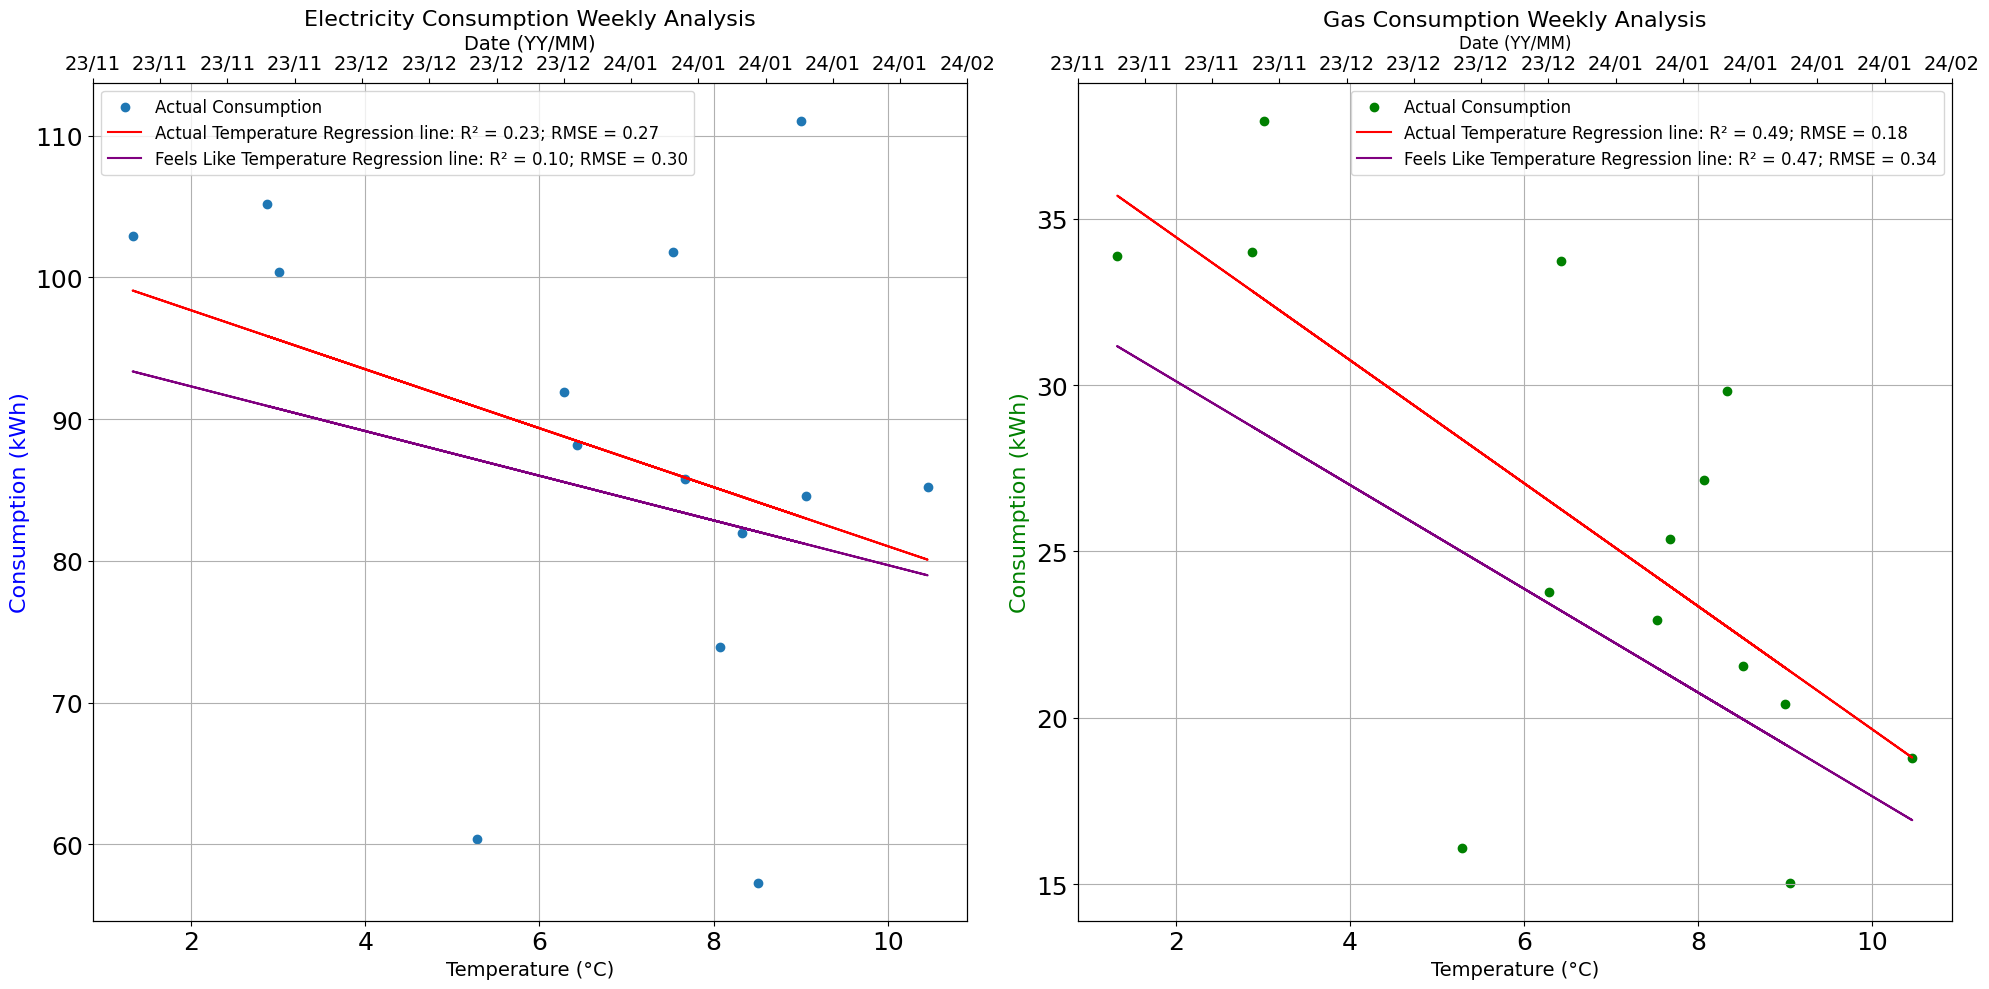

In [14]:

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot for Electricity Consumption Weekly Analysis
axs[0].scatter(weather_data_relevant_weekly['temp'], filtered_elec_weekly['Consumption (kWh)'], label='Actual Consumption')
axs[0].plot(weather_data_relevant_weekly['temp'], poly1(weather_data_relevant_weekly['temp']), color='red', label=f'Actual Temperature Regression line: R² = 0.23; RMSE = 0.27')
axs[0].plot(weather_data_relevant_weekly['temp'], slope_1a * weather_data_relevant_weekly['temp'] + intercept_1a, color='purple', label=f'Feels Like Temperature Regression line: R² = {r_value_1a**2:.2f}; RMSE = 0.30')

# Set secondary x-axis for dates
ax2 = axs[0].twiny()
ax2.set_xlabel('Date (YY/MM)',fontsize='14')

# Convert dates to yy/mm format
date_formatted = weather_data_relevant_weekly['datetime'].dt.strftime('%y/%m')

# Set limits for the secondary x-axis
ax2.set_xlim(weather_data_relevant_weekly['temp'].min(), weather_data_relevant_weekly['temp'].max())
# Set ticks for the secondary x-axis
ax2.set_xticks(np.linspace(weather_data_relevant_weekly['temp'].min(), weather_data_relevant_weekly['temp'].max(), len(date)))
# Set labels for the secondary x-axis
ax2.set_xticklabels(date_formatted, rotation=0, fontsize=14)  # Increased font size to 12


# Set labels, title, legend, and grid
axs[0].set_xlabel('Temperature (°C)', fontsize=14)  # Increased font size to 14
axs[0].set_ylabel('Consumption (kWh)', fontsize=16,color='blue')  # Increased font size to 14
axs[0].set_title('Electricity Consumption Weekly Analysis', fontsize=16)  # Increased font size to 16
axs[0].legend(fontsize=12)  # Increased font size to 12
axs[0].grid(True, which='both')

# Set ticks for the primary x-axis
axs[0].tick_params(axis='x', labelsize=14)  # Increase font size to 14
# Set ticks for the y-axis
axs[0].tick_params(axis='y', labelsize=14)  # Increase font size to 14

# Plot for Gas Consumption Weekly Analysis
axs[1].scatter(weather_data_relevant_weekly['temp'], filtered_gas_weekly['Consumption (Kwh)'],color = 'green', label='Actual Consumption')
axs[1].plot(weather_data_relevant_weekly['temp'], poly2(weather_data_relevant_weekly['temp']), color='red', label=f'Actual Temperature Regression line: R² = {r_value2a**2:.2f}; RMSE = 0.18')
axs[1].plot(weather_data_relevant_weekly['temp'], slope2a * weather_data_relevant_weekly['temp'] + intercept2a, color='purple', label=f'Feels Like Temperature Regression line: R² = {r_value2**2:.2f}; RMSE = 0.34')

# Set secondary x-axis for dates
ax2 = axs[1].twiny()
ax2.set_xlabel('Date (YY/MM)',fontsize='12')

# Convert dates to yy/mm format
date_formatted = weather_data_relevant_weekly['datetime'].dt.strftime('%y/%m')

# Set limits for the secondary x-axis
ax2.set_xlim(weather_data_relevant_weekly['temp'].min(), weather_data_relevant_weekly['temp'].max())
# Set ticks for the secondary x-axis
ax2.set_xticks(np.linspace(weather_data_relevant_weekly['temp'].min(), weather_data_relevant_weekly['temp'].max(), len(date)))
# Set labels for the secondary x-axis
ax2.set_xticklabels(date_formatted, rotation=0, fontsize=14)  # Increased font size to 12

# Set labels, title, legend, and grid
axs[1].set_xlabel('Temperature (°C)', fontsize=14)  # Increased font size to 14
axs[1].set_ylabel('Consumption (kWh)', fontsize=16,color='green')  # Increased font size to 14
axs[1].set_title('Gas Consumption Weekly Analysis', fontsize=16)  # Increased font size to 16
axs[1].legend(fontsize=12)  # Increased font size to 12
axs[1].grid(True, which='both')

# Set ticks for the primary x-axis
axs[1].tick_params(axis='x', labelsize=18)  # Increase font size to 14
# Set ticks for the y-axis
axs[1].tick_params(axis='y', labelsize=18)  # Increase font size to 14

# Set ticks for the primary x-axis
axs[0].tick_params(axis='x', labelsize=18)  # Increase font size to 14
# Set ticks for the y-axis
axs[0].tick_params(axis='y', labelsize=18)  # Increase font size to 14

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()














Gas Daily

### Model Testing for same Time period

In [15]:
# electrcity
E_weekly_model = Weekly_elec_stats['slope'] * weather_data_relevant_weekly['temp'] + Weekly_elec_stats['intercept']
E_daily_model =  Daily_elec_stats['slope'] * weather_data_relevant_daily['temp'] + Daily_elec_stats['intercept']

# Gas
G_weekly_model =  Weekly_gas_stats['slope'] * weather_data_relevant_weekly['temp'] + Weekly_gas_stats['intercept']
G_daily_model =  Daily_gas_stats['slope'] * weather_data_relevant_daily['temp'] + Daily_gas_stats['intercept']

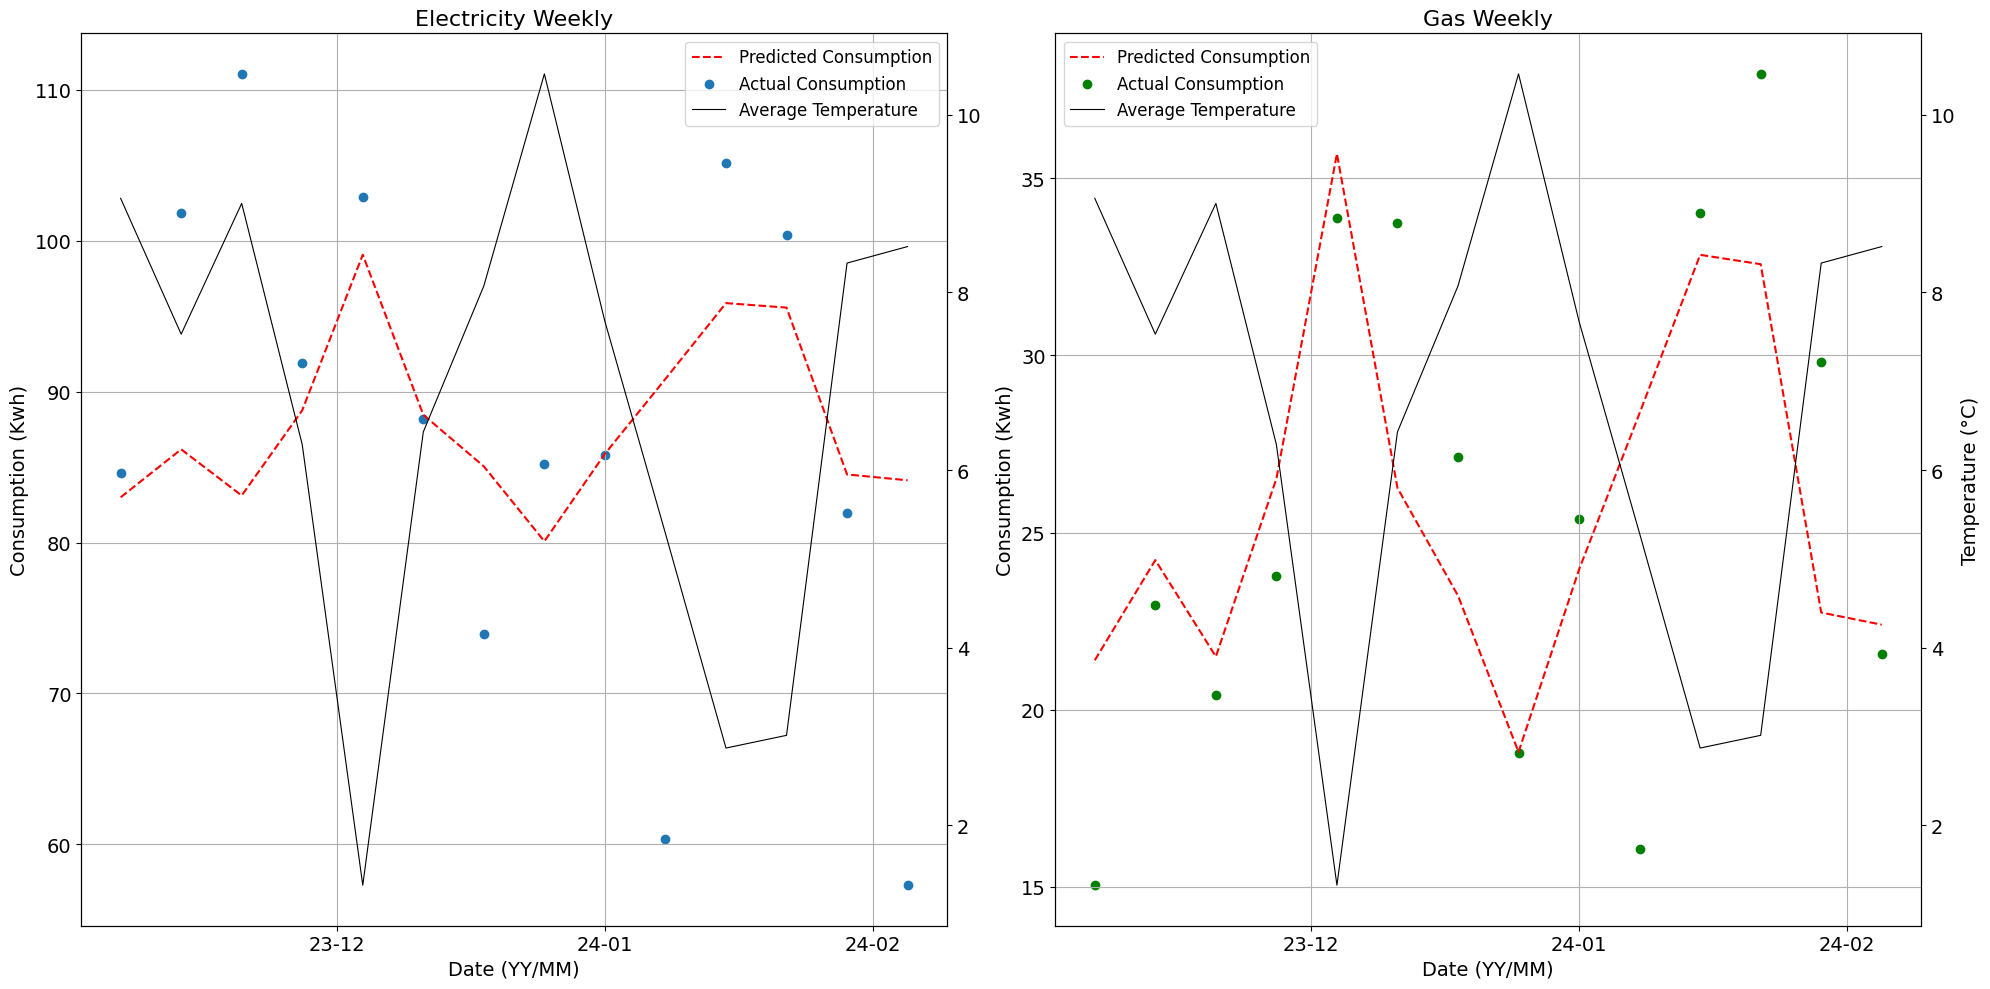

In [16]:
# @title Predicting train data subplots


# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot for Electricity Weekly
axs[0].plot(weather_data_relevant_weekly['datetime'], E_weekly_model, 'r--', label='Predicted Consumption')
axs[0].scatter(filtered_elec_weekly['date'], filtered_elec_weekly['Consumption (kWh)'], label='Actual Consumption')

# Create second y-axis for temperature
ax2 = axs[0].twinx()
temp_line = ax2.plot(weather_data_relevant_weekly['datetime'], weather_data_relevant_weekly['temp'], color='k', linewidth=0.8, label='Average Temperature')
# ax2.set_ylabel('Temperature (°C)', color='k')
ax2.tick_params(axis='y', labelcolor='k',labelsize=14)

# Set monthly intervals for x-axis
locator = MonthLocator(interval=1)
formatter = DateFormatter('%y-%m')
axs[0].xaxis.set_major_locator(locator)
axs[0].xaxis.set_major_formatter(formatter)

# Titles, labels, legend, and grid
axs[0].set_title('Electricity Weekly', fontsize=16)
axs[0].set_xlabel('Date (YY/MM)', fontsize=14)
axs[0].set_ylabel('Consumption (Kwh)', color='k', fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].grid(True, which='both')
lines1, labels1 = axs[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axs[0].legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=12)

# Plot for Gas Weekly
axs[1].plot(weather_data_relevant_weekly['datetime'], G_weekly_model, 'r--', label='Predicted Consumption')
axs[1].scatter(filtered_elec_weekly['date'], filtered_gas_weekly['Consumption (Kwh)'], color='green', label='Actual Consumption')

# Create second y-axis for temperature
ax2 = axs[1].twinx()
temp_line = ax2.plot(weather_data_relevant_weekly['datetime'], weather_data_relevant_weekly['temp'], color='k', linewidth=0.8, label='Average Temperature')
ax2.set_ylabel('Temperature (°C)', color='k', fontsize=14)
ax2.tick_params(axis='y', labelcolor='k',labelsize=14)

# Set monthly intervals for x-axis
axs[1].xaxis.set_major_locator(locator)
axs[1].xaxis.set_major_formatter(formatter)

# Titles, labels, legend, and grid
axs[1].set_title('Gas Weekly', fontsize=16)
axs[1].set_xlabel('Date (YY/MM)', fontsize=14)
axs[1].set_ylabel('Consumption (Kwh)', color='k', fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[1].grid(True, which='both')
lines1, labels1 = axs[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axs[1].legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

In [17]:
er1 = np.array(G_weekly_model)-np.array(filtered_gas_weekly['Consumption (Kwh)'])/G_weekly_model
er2 = np.array(E_weekly_model)-np.array(filtered_elec_weekly['Consumption (kWh)'])/E_weekly_model
print(er1.mean(),er2.mean())

24.749382121468248 86.89012221001698


### Extrapolation for Summer period


In [18]:
#Assume model from May to September
UL = pd.to_datetime('2023-05-01')
LL =  pd.to_datetime('2023-09-01')
#weekly Desired temp data
weather_data_summer_weekly = weather_data_weekly[(weather_data_weekly['datetime'] >= UL)]
weather_data_summer_weekly = weather_data_summer_weekly[(weather_data_summer_weekly['datetime'] < '2023-09-06')]

# Daily Desired temp data
weather_data_summer_daily = weather_data[(weather_data['datetime'] >= UL)]
weather_data_summer_daily = weather_data_summer_daily[(weather_data_summer_daily['datetime'] <= LL)]


In [19]:
#Getting gas and elec data for same period


# Set a specific date threshold
# Filter rows after the threshold date
summer_elec_daily = elec_daily_consumption[elec_daily_consumption['date'] >= UL]
summer_elec_daily = summer_elec_daily[elec_daily_consumption['date'] <= LL]
summer_gas_daily = Gas_daily_consumption[Gas_daily_consumption['Date'] >= UL]
summer_gas_daily = summer_gas_daily[Gas_daily_consumption['Date'] <= LL]


#turning these into weekly

# Set 'date' as the index
summer_elec_daily.set_index('date', inplace=True)

# Resample data to weekly frequency and sum the values
summer_elec_weekly = summer_elec_daily.resample('W-Mon').sum()

# Reset the index to make 'date' a regular column again
summer_elec_daily.reset_index(inplace=True)
summer_elec_weekly.reset_index(inplace=True)


#Gas

# Set 'date' as the index
summer_gas_daily.set_index('Date', inplace=True)

# Resample data to weekly frequency and sum the values
summer_gas_weekly = summer_gas_daily.resample('W-Mon').sum()

# Reset the index to make 'date' a regular column again
summer_gas_weekly.reset_index(inplace=True)
summer_gas_daily.reset_index(inplace=True)




<ipython-input-19-12c6bc924e68>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  summer_elec_daily = summer_elec_daily[elec_daily_consumption['date'] <= LL]
<ipython-input-19-12c6bc924e68>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  summer_gas_daily = summer_gas_daily[Gas_daily_consumption['Date'] <= LL]


In [20]:
# electrcity
E_weekly_model = Weekly_elec_stats['slope'] * weather_data_summer_weekly['temp'] + Weekly_elec_stats['intercept']
E_daily_model =  Daily_elec_stats['slope'] * weather_data_summer_daily['temp'] + Daily_elec_stats['intercept']

# Gas
G_weekly_model =  Weekly_gas_stats['slope'] * weather_data_summer_weekly['temp'] + Weekly_gas_stats['intercept']
G_daily_model =  Daily_gas_stats['slope'] * weather_data_summer_daily['temp'] + Daily_gas_stats['intercept']

In [ ]:

# Create subplots
fig, ax1 = plt.subplots(1, 2, figsize=(20, 10))

# Plot for Electricity Consumption
ax1[0].plot(weather_data_summer_weekly['datetime'], E_weekly_model, 'r--', label='Predicted Consumption')
ax1[0].scatter(summer_elec_weekly['date'], summer_elec_weekly['Consumption (kWh)'], label='Actual Consumption')
ax1[0].set_xlabel('Date (YY/MM)', fontsize=14)  # Increase fontsize for x-axis label
ax1[0].set_ylabel('Consumption (KWh)', color='k', fontsize=14)  # Increase fontsize for y-axis label
ax1[0].tick_params(axis='both', labelcolor='k', which='both', labelsize=14)  # Increase size of both x and y ticks
ax1[0].tick_params(axis='y', labelcolor='k', labelsize=14)  # Increase size of primary y-axis ticks
ax2 = ax1[0].twinx()
ax2.plot(weather_data_summer_weekly['datetime'], weather_data_summer_weekly['temp'], color='k', label='Mean Temperature', linewidth=0.8)
#ax2.set_ylabel('Temperature (°C)', color='k', fontsize=14)  # Increase fontsize for secondary y-axis label
ax2.tick_params(axis='y', labelcolor='k', labelsize=14)  # Increase size of secondary y ticks

# Set monthly intervals for x-axis
locator = MonthLocator(interval=1)
formatter = DateFormatter('%y-%m')
ax1[0].xaxis.set_major_locator(locator)
ax1[0].xaxis.set_major_formatter(formatter)

ax1[0].grid(True, which='both')
lines1, labels1 = ax1[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1[0].legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=12)  # Increase fontsize of legend labels
ax1[0].set_title('Weekly Electricity Consumption and Average Temperature (Summer)')

# Plot for Gas Consumption
ax1[1].plot(weather_data_summer_weekly['datetime'], G_weekly_model, 'r--', label='Gas Consumption Model')
ax1[1].scatter(summer_gas_weekly['Date'], summer_gas_weekly['Consumption (Kwh)'], label='Gas Consumption Data', color='green')
ax1[1].set_xlabel('Date (YY/MM)', fontsize=14)  # Increase fontsize for x-axis label
ax1[1].set_ylabel('Consumption (Kwh)', color='k', fontsize=14)  # Increase fontsize for y-axis label
ax1[1].tick_params(axis='both', labelcolor='k', which='both', labelsize=14)  # Increase size of both x and y ticks
ax1[1].tick_params(axis='y', labelcolor='k', labelsize=14)  # Increase size of primary y-axis ticks
ax2 = ax1[1].twinx()
ax2.plot(weather_data_summer_weekly['datetime'], weather_data_summer_weekly['temp'], color='k', label='Mean Temperature', linewidth=0.7)
ax2.set_ylabel('Temperature (°C)', color='k', fontsize=14)  # Increase fontsize for secondary y-axis label
ax2.tick_params(axis='y', labelcolor='k', labelsize=14)  # Increase size of secondary y ticks

# Set monthly intervals for x-axis
ax1[1].xaxis.set_major_locator(locator)
ax1[1].xaxis.set_major_formatter(formatter)

ax1[1].grid(True, which='both')
lines1, labels1 = ax1[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1[1].legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=12)  # Increase fontsize of legend labels
ax1[1].set_title('Weekly Gas Consumption and Average Temperature (Summer)')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()


### 2022 November till now comparison

In [ ]:
path = 'https://github.com/Aadam03/Efficient-Use-of-Energy/raw/main/Longer%20weather%20Data.xlsx'


longer_weather_data = pd.read_excel(path)

longer_weather_data['datetime'] = pd.to_datetime(longer_weather_data['datetime'])
UL = pd.to_datetime('2022-11-01')
LL =  pd.to_datetime('2024-02-03')

longer_weather_relevant_daily = longer_weather_data[(longer_weather_data['datetime'] >= UL)]
longer_weather_relevant_daily = longer_weather_relevant_daily[(longer_weather_relevant_daily['datetime'] <= LL)]



# # Set 'date' as the index
longer_weather_relevant_daily.set_index('datetime', inplace=True)

# # Resample data to weekly frequency and sum the values
longer_weather_relevant_weekly = longer_weather_relevant_daily.resample('W-Mon').mean()

# # Reset the index to make 'date' a regular column again
longer_weather_relevant_weekly.reset_index(inplace=True)

longer_weather_relevant_daily.reset_index(inplace=True)



In [ ]:
UL = pd.to_datetime('2022-11-01')
LL =  pd.to_datetime('2024-02-03')

Gas_weekly_rel = Gas_weekly[(Gas_weekly['Date'] >= UL)]
Gas_weekly_rel = Gas_weekly_rel[(Gas_weekly_rel['Date'] <= LL)]


elec_weekly_rel = elec_weekly[(elec_weekly['date'] >= UL)]
elec_weekly_rel = elec_weekly_rel[(elec_weekly['date'] <= LL)]


### Applying model

In [ ]:
# @title Extrapolating for given timeframe

# electrcity
E_weekly_model = Weekly_elec_stats['slope'] * longer_weather_relevant_weekly['temp'] + Weekly_elec_stats['intercept']

# Gas
G_weekly_model =  Weekly_gas_stats['slope'] * longer_weather_relevant_weekly['temp'] + Weekly_gas_stats['intercept']

In [ ]:
# @title Subplotting the extrapolation plots

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot for Electricity Consumption
axs[0].plot(longer_weather_relevant_weekly['datetime'], E_weekly_model, 'r--', label='Predicted Consumption')
axs[0].scatter(elec_weekly_rel['date'], elec_weekly_rel['Consumption (kWh)'], label='Actual Consumption')
axs[0].set_xlabel('Date (YY/MM)', fontsize=14)  # Increase fontsize for x-axis label
axs[0].set_ylabel('Consumption (KWh)', color='k', fontsize=16)  # Increase fontsize for y-axis label
axs[0].tick_params(axis='both', labelcolor='k', labelsize=16)  # Increase size of both x and y ticks
ax2 = axs[0].twinx()
ax2.plot(longer_weather_relevant_weekly['datetime'], longer_weather_relevant_weekly['temp'], color='k', label='Mean Temperature', linewidth=0.7)
#ax2.set_ylabel('Temperature', color='k', fontsize=14)  # Increase fontsize for secondary y-axis label
ax2.tick_params(axis='y', labelcolor='k', labelsize=16)  # Increase size of secondary y ticks

# Set monthly intervals for x-axis
locator = MonthLocator(interval=2)
formatter = DateFormatter('%y-%m')
axs[0].xaxis.set_major_locator(locator)
axs[0].xaxis.set_major_formatter(formatter)

axs[0].grid(True, which='both')
lines1, labels1 = axs[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axs[0].legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)  # Increase fontsize of legend labels
axs[0].set_title('Weekly Electricity Consumption and Average Temperature from November 2022')

# Plot for Gas Consumption
axs[1].plot(longer_weather_relevant_weekly['datetime'], G_weekly_model, 'r--', label='Predicted Consumption')
axs[1].scatter(Gas_weekly_rel['Date'], Gas_weekly_rel['Consumption (Kwh)'], label='Actual Consumption', color='green')
axs[1].set_xlabel('Date (YY/MM)', fontsize=14)  # Increase fontsize for x-axis label
axs[1].set_ylabel('Consumption (KWh)', color='k', fontsize=16)  # Increase fontsize for y-axis label
axs[1].tick_params(axis='both', labelcolor='k', labelsize=16)  # Increase size of both x and y ticks
ax2 = axs[1].twinx()
ax2.plot(longer_weather_relevant_weekly['datetime'], longer_weather_relevant_weekly['temp'], color='k', label='Mean Temperature', linewidth=0.7)
ax2.set_ylabel('Temperature (°C)', color='k', fontsize=16)  # Increase fontsize for secondary y-axis label
ax2.tick_params(axis='y', labelcolor='k', labelsize=16)  # Increase size of secondary y ticks

# Set monthly intervals for x-axis
axs[1].xaxis.set_major_locator(locator)
axs[1].xaxis.set_major_formatter(formatter)

axs[1].grid(True, which='both')
lines1, labels1 = axs[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axs[1].legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=14)  # Increase fontsize of legend labels
axs[1].set_title('Weekly Gas Consumption and Average Temperature from November 2022')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()



### Improving Model by training with more data and doing a segmented Regression

### Summer Electric Regression

In [ ]:
# Calculate R-squared and other statistical parameters using scipy's linregress
slope, intercept, r_value, p_value, std_err = linregress(weather_data_summer_weekly['temp'], summer_elec_weekly['Consumption (kWh)'])
r_squared = r_value**2



# Compute predicted values
predicted_values_summer = slope * weather_data_summer_weekly['temp'] + intercept

# Calculate RMSE
rmse_summer = np.sqrt(mean_squared_error(summer_elec_weekly['Consumption (kWh)'], predicted_values_summer))

# Calculate the range of the target variable
target_range_summer = summer_elec_weekly['Consumption (kWh)'].max() - summer_elec_weekly['Consumption (kWh)'].min()

# Calculate normalized RMSE
normalized_rmse_summer = rmse_summer / target_range_summer
print("Normalized RMSE for the seventh model:", normalized_rmse_summer)

summer_elec_regression_stats = {
    'slope': slope,
    'intercept': intercept,
    'r_squared': r_squared,
    'p_value': p_value,
    'std_err': std_err
}



### Summer Gas Regression Data

In [ ]:
# # Calculate R-squared and other statistical parameters using scipy's linregress
# slope, intercept, r_value, p_value, std_err = linregress(weather_data_summer_weekly['temp'], summer_gas_weekly['Consumption (Kwh)'])
# r_squared = r_value**2

# summer_gas_regression_stats = {
#     'slope': slope,
#     'intercept': intercept,
#     'r_squared': r_squared,
#     'p_value': p_value,
#     'std_err': std_err
# }


In [ ]:
# @title Gas summer regression


# Perform regression using linregress
slope_g, intercept_g, r_value_g, p_value_g, std_err_g = linregress(weather_data_summer_weekly['temp'], summer_gas_weekly['Consumption (Kwh)'])


# Compute predicted values
predicted_values_summer_gas = slope_g * weather_data_summer_weekly['temp'] + intercept_g

# Calculate RMSE
rmse_summer_gas = np.sqrt(mean_squared_error(summer_gas_weekly['Consumption (Kwh)'], predicted_values_summer_gas))

# Calculate the range of the target variable
target_range_summer_gas = summer_gas_weekly['Consumption (Kwh)'].max() - summer_gas_weekly['Consumption (Kwh)'].min()

# Calculate normalized RMSE
normalized_rmse_summer_gas = rmse_summer_gas / target_range_summer_gas





# Calculate R-squared
r_squared_g = r_value_g**2



# Perform regression using linregress
slope_g2, intercept_g2, r_value_g2, p_value_g2, std_err_g2 = linregress(weather_data_summer_weekly['feelslike'], summer_gas_weekly['Consumption (Kwh)'])



# Compute predicted values
predicted_values_summer_gas2 = slope_g2 * weather_data_summer_weekly['feelslike'] + intercept_g2

# Calculate RMSE
rmse_summer_gas2 = np.sqrt(mean_squared_error(summer_gas_weekly['Consumption (Kwh)'], predicted_values_summer_gas2))

# Calculate the range of the target variable
target_range_summer_gas2 = summer_gas_weekly['Consumption (Kwh)'].max() - summer_gas_weekly['Consumption (Kwh)'].min()

# Calculate normalized RMSE
normalized_rmse_summer_gas2 = rmse_summer_gas2 / target_range_summer_gas2

# Calculate R-squared
r_squared_g2 = r_value_g2**2


In [ ]:
# @title Electric summer regression


# Perform regression using linregress with actual temp
slope_s, intercept_s, r_value_s, p_value_s, std_err_s = linregress(weather_data_summer_weekly['temp'], summer_elec_weekly['Consumption (kWh)'])
# Compute predicted values
predicted_values_summer_s = slope_s * weather_data_summer_weekly['temp'] + intercept_s

# Calculate RMSE
rmse_summer_s = np.sqrt(mean_squared_error(summer_elec_weekly['Consumption (kWh)'], predicted_values_summer_s))

# Calculate the range of the target variable
target_range_summer_s = summer_elec_weekly['Consumption (kWh)'].max() - summer_elec_weekly['Consumption (kWh)'].min()

# Calculate normalized RMSE
normalized_rmse_summer_s = rmse_summer_s / target_range_summer_s




# Calculate R-squared
r_squared_s = r_value_s**2


# Perform regression using linregress with 'what it feels like temp'
slope_s2, intercept_s2, r_value_s2, p_value_s2, std_err_s2 = linregress(weather_data_summer_weekly['feelslike'], summer_elec_weekly['Consumption (kWh)'])
# Compute predicted values
predicted_values_summer_s2 = slope_s2 * weather_data_summer_weekly['feelslike'] + intercept_s2

# Calculate RMSE
rmse_summer_s2 = np.sqrt(mean_squared_error(summer_elec_weekly['Consumption (kWh)'], predicted_values_summer_s2))

# Calculate the range of the target variable
target_range_summer_s2 = summer_elec_weekly['Consumption (kWh)'].max() - summer_elec_weekly['Consumption (kWh)'].min()

# Calculate normalized RMSE
normalized_rmse_summer_s2 = rmse_summer_s2 / target_range_summer_s2



# Calculate R-squared
r_squared_s2 = r_value_s2**2



In [ ]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot for Gas Consumption
axs[1].scatter(weather_data_summer_weekly['temp'], summer_gas_weekly['Consumption (Kwh)'], label='Actual Consumption',color='green')
axs[1].plot(weather_data_summer_weekly['temp'], slope_g * weather_data_summer_weekly['temp'] + intercept_g, color='red', linestyle='dashed', label=f'Actual Temperature Regression line: R² = {r_value_g**2:.2f}; RMSE = 0.17', linewidth=2)
axs[1].plot(weather_data_summer_weekly['feelslike'], slope_g2 * weather_data_summer_weekly['feelslike'] + intercept_g2, color='purple', linestyle='dashed', label=f'Feels Like Temperature Regression line: R² = {r_value_g2**2:.3f};RMSE = 0.17', linewidth=2)
axs[1].set_xlabel('Temperature (°C)', fontsize=16)
axs[1].set_ylabel('Consumption (kWh)', fontsize=16,color='green')
axs[1].set_title('Summer Gas Consumption Weekly Analysis', fontsize=20)
axs[1].legend(fontsize=14)
axs[1].grid()
axs[1].tick_params(axis='both', which='major', labelsize=16)  # Increase tick size

# Plot for Electricity Consumption
axs[0].scatter(weather_data_summer_weekly['temp'], summer_elec_weekly['Consumption (kWh)'], label='Actual Consumption')
axs[0].plot(weather_data_summer_weekly['temp'], slope_s * weather_data_summer_weekly['temp'] + intercept_s, color='red', linestyle='dashed', label=f'Actual Temperature Regression line: R² = {r_value_s**2:.2f}; RMSE = 0.16', linewidth=2)
axs[0].plot(weather_data_summer_weekly['feelslike'], slope_s2 * weather_data_summer_weekly['feelslike'] + intercept_s2, color='purple', linestyle='dashed', label=f'Feels Like Temperature Regression line: R² = {r_value_s2**2:.3f};RMSE = 0.17', linewidth=2)
axs[0].set_xlabel('Temperature (°C)', fontsize=16)
axs[0].set_ylabel('Consumption (kWh)', fontsize=16,color='blue')
axs[0].set_title('Summer Electricity Consumption Weekly Analysis', fontsize=20)
axs[0].legend(fontsize=14, loc='upper left')  # Corrected the location parameter
axs[0].grid()
axs[0].tick_params(axis='both', which='major', labelsize=16)  # Increase tick size

# Show plots
plt.tight_layout()
plt.show()



# Electric

In [ ]:
# @title electic data handling
UL = pd.to_datetime('2023-05-01')
LL = pd.to_datetime('2024-02-06')
weather_needed =  weather_data_weekly[(weather_data_weekly['datetime'] >= UL)]
weather_needed = weather_needed[(weather_needed['datetime'] <= LL)]
elec_consumption = elec_weekly[elec_weekly['date']>=UL]
elec_consumption = elec_consumption[elec_consumption['date']<=LL]



### Gas

In [ ]:
# @title Gas Data Handling

UL = pd.to_datetime('2023-05-01')
LL = pd.to_datetime('2024-02-06')
weather_needed =  weather_data_weekly[(weather_data_weekly['datetime'] >= UL)]
weather_needed = weather_needed[(weather_needed['datetime'] <= LL)]
Gas_consumption = Gas_weekly[Gas_weekly['Date']>=UL]
Gas_consumption = Gas_consumption[Gas_consumption['Date']<=LL]


In [ ]:
# @title Segmented regression subplot gas and electric
# Create subplots


fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot electricity consumption subplot
axs[0].plot(weather_data_summer_weekly['temp'], slope_s * weather_data_summer_weekly['temp'] + intercept_s, color='m', label=f'Summer Regression line: R² = {r_value_s**2:.2f}; RMSE = 0.16')
axs[0].plot(weather_data_relevant_weekly['temp'], poly1(weather_data_relevant_weekly['temp']), color='red', label=f'Winter Regression line: R² = 0.23 ;RMSE = 0.27')
elec_consumption = elec_weekly[(elec_weekly['date'] >= UL) & (elec_weekly['date'] <= LL)]
axs[0].scatter(weather_needed['temp'], elec_consumption['Consumption (kWh)'])
axs[0].set_title('Electric Segmented Regression', fontsize=16)  # Increase fontsize for subplot title
axs[0].set_xlabel('Temperature (°C)', fontsize=16)  # Increase fontsize for x-axis label
axs[0].set_ylabel('Consumption kWh', fontsize=16)  # Increase fontsize for y-axis label
axs[0].tick_params(axis='both', labelsize=16)  # Increase fontsize for both x and y ticks
axs[0].grid()
axs[0].legend(fontsize=12)  # Increase fontsize for legend

# Plot gas consumption subplot
axs[1].plot(weather_data_summer_weekly['temp'], slope_g * weather_data_summer_weekly['temp'] + intercept_g, color='m', label=f'Summer Regression line: R² = 0.68; RSME = 0.17')
axs[1].plot(weather_data_relevant_weekly['temp'], poly2(weather_data_relevant_weekly['temp']), color='red', label=f'Winter Regression line: R² = {r_value2**2:.2f}; RMSE = 0.18')
gas_consumption = Gas_weekly[(Gas_weekly['Date'] >= UL) & (Gas_weekly['Date'] <= LL)]
axs[1].scatter(weather_needed['temp'], gas_consumption['Consumption (Kwh)'], color='green')
axs[1].set_title('Gas Segmented Regression', fontsize=16)  # Increase fontsize for subplot title
axs[1].set_xlabel('Temperature (°C)', fontsize=16)  # Increase fontsize for x-axis label
axs[1].set_ylabel('Consumption kWh', fontsize=16)  # Increase fontsize for y-axis label
axs[1].tick_params(axis='both', labelsize=16)  # Increase fontsize for both x and y ticks
axs[1].grid()
axs[1].legend(fontsize=12)  # Increase fontsize for legend

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [ ]:

RMSE_summer_reg = {'elec_T' : normalized_rmse_summer_s,
                      'elec_FT': normalized_rmse_summer_gas,
                      'Gas_T' : normalized_rmse_summer_s2,
                      'Gas_FT': normalized_rmse_summer_gas2


}


RMSE_SEG_REG  = { 'Summer_elec_T': normalized_rmse_summer_s,
                 'Winter_elec_T': normalized_rmse_ed,
                  'Summer_gas_T': normalized_rmse_summer_s2 ,
                  'Winter_gas_T': normalized_rmse_ge,

}

RMSE_winter_reg = {
    'Elec_T ' : normalized_rmse1,
    'Elec_FT' : normalized_rmse_a,
    'Gas_T'   : normalized_rmse_gas,
    'Gas_FT'  : normalized_rmse_gas_a
}

Daily_RMSE = { 'Elec' : normalized_rmse1,
               'Gas'  : normalized_rmse_gas

}

In [ ]:
RMSE_SEG_REG

### Extrapolation

In [ ]:
# @title Segregation data handling
UL = '2022-05-01'
LL = '2024-02-06'

electrcity_data = elec_weekly[elec_weekly['date'] >= UL]

electrcity_data = electrcity_data[electrcity_data['date'] <= LL]


Gaseous_data = Gas_weekly[Gas_weekly['Date'] >= UL]

Gaseous_data = Gaseous_data[Gaseous_data['Date'] <= LL]



Path = 'https://github.com/Aadam03/Efficient-Use-of-Energy/raw/main/long%20data.xlsx'

weather_data = pd.read_excel(Path)


weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

weather_data_relevant_daily = weather_data[(weather_data['datetime'] >= UL)]
weather_data_relevant_daily = weather_data_relevant_daily[(weather_data_relevant_daily['datetime'] <= LL)]


weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
# Set 'date' as the index
weather_data.set_index('datetime', inplace=True)

# Resample data to weekly frequency and sum the values
weather_data_weekly = weather_data.resample('W-Mon').mean()

# # Reset the index to make 'date' a regular column again
weather_data_weekly.reset_index(inplace=True)

weather_data.reset_index(inplace=True)


weather_data_weekly = weather_data_weekly[weather_data_weekly['datetime'] >= UL]
weather_data_weekly = weather_data_weekly[weather_data_weekly['datetime'] <= LL]



weather_data_summer22 = weather_data_weekly[weather_data_weekly['datetime'] >= UL]
weather_data_summer22 = weather_data_summer22[weather_data_summer22['datetime'] <= '2022-10-01']

weather_data_winter22 = weather_data_weekly[weather_data_weekly['datetime'] >= '2022-10-01']
weather_data_winter22 = weather_data_winter22[weather_data_winter22['datetime'] <= '2023-05-01']


weather_data_summer23 = weather_data_weekly[weather_data_weekly['datetime'] >= '2023-05-01']
weather_data_summer23 = weather_data_summer23[weather_data_summer23['datetime'] <= '2023-10-01']

weather_data_winter23 = weather_data_weekly[weather_data_weekly['datetime'] >= '2023-10-01']
weather_data_winter23 = weather_data_winter23[weather_data_winter23['datetime'] <= LL]


In [ ]:
# @title Segregation regression analysis
# electrcity

E_slope_W, E_int_W= poly1

G_slope_W, G_int_W = np.polyfit(weather_data_relevant_weekly['temp'], filtered_gas_weekly['Consumption (Kwh)'], deg=1)

#ELEC
E_weekly_winter22 = E_slope_W * weather_data_winter22['temp'] + E_int_W
E_weekly_summer22 = slope_s* weather_data_summer22['temp'] + intercept_s

E_weekly_winter23 = E_slope_W * weather_data_winter23['temp'] + E_int_W
E_weekly_summer23 = slope_s* weather_data_summer23['temp'] + intercept_s

# Gas
G_weekly_winter22 = G_slope_W *  weather_data_winter22['temp'] + G_int_W
G_weekly_summer22 =  slope_g * weather_data_summer22['temp'] + intercept_g

G_weekly_winter23 = G_slope_W *  weather_data_winter23['temp'] + G_int_W
G_weekly_summer23 =  slope_g * weather_data_summer23['temp'] + intercept_g

In [ ]:
# @title Plotting segmented regression extrapolation
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter

# Create the first subplot for electricity consumption
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(18, 8))

# Scatter plot for electricity consumption
ax1.scatter(electrcity_data['date'], electrcity_data['Consumption (kWh)'], label='Actual Consumption', color='blue')
ax1.plot(weather_data_summer22['datetime'], E_weekly_summer22, 'r--', label='Summer model')
ax1.set_title('Predicted and Actual Electricity Consumptions from 2022')
ax1.plot(weather_data_winter22['datetime'], E_weekly_winter22, 'm--', label='Winter Model')
ax1.plot(weather_data_summer23['datetime'], E_weekly_summer23, 'r--')
ax1.plot(weather_data_winter23['datetime'], E_weekly_winter23, 'm--')


# Twin the axis for temperature plot
ax2 = ax1.twinx()
ax2.plot(weather_data_weekly['datetime'], weather_data_weekly['temp'], color='k', label='Mean Temperature', linewidth=0.7)

# Date formatting
locator = MonthLocator(interval=2)  # Set the interval to 2 months
formatter = DateFormatter('%y/%m')

# Set the date formatting for the x-axis
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax1.grid()

# Set y-axis labels
ax1.set_ylabel('Consumption (kWh)', color='blue')

# Rotate and align the tick labels so they look better
fig.autofmt_xdate()

# Show the plot with legend adjusted
ax1.legend(loc='lower left', fontsize='small',bbox_to_anchor=(0.07, 0))
ax2.legend(loc='lower right', fontsize='small')

# Second subplot for gaseous consumption
# Scatter plot for gaseous consumption
ax3.scatter(Gaseous_data['Date'], Gaseous_data['Consumption (Kwh)'], label='Actual Consumption', color='green')
ax3.plot(weather_data_summer22['datetime'], G_weekly_summer22, 'r--', label='Summer Model')
ax3.plot(weather_data_winter22['datetime'], G_weekly_winter22, 'm--', label = 'Winter Model')
ax3.plot(weather_data_summer23['datetime'], G_weekly_summer23, 'r--')
ax3.plot(weather_data_winter23['datetime'], G_weekly_winter23, 'm--')
ax3.set_title('Predicted and Actual Gas Consumptions from 2022')

# Twin the axis for temperature plot
ax4 = ax3.twinx()
ax4.plot(weather_data_weekly['datetime'], weather_data_weekly['temp'], color='k', label='Mean Temperature', linewidth=0.7)

# Date formatting
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax3.grid()

# Set y-axis labels
ax3.set_ylabel('Consumption (kWh)', color='green')
ax4.set_ylabel('Temperature (°C)', color='black')

# Rotate and align the tick labels so they look better
fig.autofmt_xdate()

# Show the plot with legend adjusted
ax3.legend(loc='lower left', fontsize='small',bbox_to_anchor=(0.77, 0.85))
ax4.legend(loc='lower right', fontsize='small')

plt.tight_layout()
plt.show()


In [ ]:
all_E_values = np.concatenate([E_weekly_summer22, E_weekly_winter22, E_weekly_summer23, E_weekly_winter23])
all_G_values = np.concatenate([G_weekly_summer22, G_weekly_winter22, G_weekly_summer23, G_weekly_winter23])
all_T = np.concatenate([weather_data_summer22['datetime'],weather_data_winter22['datetime'],weather_data_summer23['datetime'],weather_data_winter23['datetime']])
all_Temps = np.concatenate([weather_data_summer22['temp'],weather_data_winter22['temp'],weather_data_summer23['temp'],weather_data_winter23['temp']])

In [ ]:

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot for Electricity Consumption
axs[0].scatter(electrcity_data['date'], electrcity_data['Consumption (kWh)'], label='Actual Consumption', color='blue')
axs[0].plot(all_T, all_E_values, 'r--', label='Predicted Consumption')
axs[0].set_ylabel('Consumption (kWh)', fontsize=16, color='black')
axs[0].set_xlabel('Date (YY/MM)', fontsize=16, color='black')
axs[0].grid()
axs[0].set_title('Electricity Consumption', fontsize=16, color='black')

# Set monthly intervals for x-axis
locator = MonthLocator(interval=3)
formatter = DateFormatter('%y/%m')
axs[0].xaxis.set_major_locator(locator)
axs[0].xaxis.set_major_formatter(formatter)
axs[0].tick_params(axis='both', which='major', labelsize=16, colors='black')

# Add second y-axis for first subplot
axs01 = axs[0].twinx()
axs01.plot(all_T, all_Temps, 'k-', label='Temperature',linewidth=0.8)
#axs01.set_ylabel('Mean Weekly Temperature', fontsize=16, color='black')
axs01.tick_params(axis='y', labelsize=16, colors='black')

# Plot for Gas Consumption
axs[1].scatter(Gaseous_data['Date'], Gaseous_data['Consumption (Kwh)'], label='Actual Consumption', color='green')
axs[1].plot(all_T, all_G_values, 'r--', label='Predicted Consumption')
axs[1].set_ylabel('Consumption (kWh)', fontsize=16, color='black')
axs[1].set_xlabel('Date (YY/MM)', fontsize=16, color='black')
axs[1].grid()
axs[1].set_title('Gas Consumption', fontsize=16, color='black')

# Set monthly intervals for x-axis
axs[1].xaxis.set_major_locator(locator)
axs[1].xaxis.set_major_formatter(formatter)
axs[1].tick_params(axis='both', which='major', labelsize=16, colors='black')

# Add second y-axis for second subplot
axs11 = axs[1].twinx()
axs11.plot(all_T, all_Temps, 'k-', label='Temperature',linewidth=0.8)
axs11.set_ylabel('Mean Weekly Temperature(°C)', fontsize=16, color='black')
axs11.tick_params(axis='y', labelsize=16, colors='black')

lines1, labels1 = axs[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axs[1].legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=14)  # Increase fontsize of legend labels

lines1, labels1 = axs[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axs[0].legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=14)  # Increase fontsize of legend labels

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


### Errors

In [ ]:
elec_seg_model_error1 =  np.abs(electrcity_data['Consumption (kWh)'] - all_E_values[0:93])/ all_E_values[0:93]
elec_seg_model_error2 =  np.abs(electrcity_data['Consumption (kWh)'] - all_E_values[0:93])/ electrcity_data['Consumption (kWh)']

elec_seg_model_error1.mean()

#plt.plot(all_Temps[0:93],elec_seg_model_error2,'.')

In [ ]:
some_E_values = np.concatenate([E_weekly_summer22, E_weekly_summer23, E_weekly_winter23])
some_Temps = np.concatenate([weather_data_summer22['temp'],weather_data_summer23['temp'],weather_data_winter23['temp']])
electrcity_data2 = electrcity_data[(electrcity_data['date'] < '2022-10-01') | (electrcity_data['date'] > '2023-05-01')]

new_error = electrcity_data2 = electrcity_data[(electrcity_data['date'] < '2022-10-01') | (electrcity_data['date'] > '2023-05-01')]

new_error = np.abs(electrcity_data2['Consumption (kWh)'] - some_E_values[0:62])/electrcity_data2['Consumption (kWh)'] * 100

new_error.mean()

In [ ]:

plt.scatter(some_Temps[0:62],new_error)

In [ ]:
some_G_values = np.concatenate([G_weekly_summer22, G_weekly_summer23, G_weekly_winter23])
some_Temps = np.concatenate([weather_data_summer22['temp'],weather_data_summer23['temp'],weather_data_winter23['temp']])
Gaseous_data2 = Gaseous_data[(Gaseous_data['Date'] < '2022-10-01') | (Gaseous_data['Date'] > '2023-05-01')]
new_error = np.abs( Gaseous_data2['Consumption (Kwh)'] - some_G_values[0:62])/ some_G_values[0:62] * 100

new_error = new_error[np.isfinite(new_error)]
new_error = new_error[new_error<200]
plt.scatter(some_Temps[0:len(new_error)],new_error)
plt.ylim(0,500)

new_error.mean()

